Sketch for prediction of SalesAmount
===

# Setup

In [1]:
##### loads a GPU-accelerated version of pandas, disable if this makes any problems!!

%load_ext cudf.pandas

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, GridSearchCV, learning_curve, LearningCurveDisplay
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor

from os import path

# Loading Data

In [3]:
### Load less data for now to try and avoid crashes
skipratio = 0.8 # elements to skip

skipsize = int(3406088 * skipratio)
skipindices = np.random.choice(np.arange(1,3406088), (skipsize), replace = False)
skipindices

array([2652441, 2865114,  591637, ..., 3303443,  848129, 1362939])

In [17]:
### For now, let's work with the dataset prepared by Nishi
data = pd.read_csv("../merged_data/data_ml_merged.csv", header = 0, skiprows = skipindices)

data.set_index(['SalesKey'], inplace=True)
data['DateKey'] = pd.to_datetime(data['DateKey'], infer_datetime_format=True)


print(data.shape)
data.head()

(681219, 40)


,DateKey,channelKey,StoreKey,ProductKey,PromotionKey,UnitCost,UnitPrice,SalesQuantity,ReturnQuantity,ReturnAmount,...,ProductCategoryKey,GeographyKey,StoreType,EmployeeCount,SellingAreaSize,GeographyType,ContinentName,CityName,StateProvinceName,RegionCountryName
SalesKey,,,,,,,,,,,,,,,,,,,,,
8,2008-04-10,2,307,138,15,229.93,499.99,9,0,0.0,...,2.0,710,Online,8,93800,City,Asia,Beijing,Beijing,China
13,2007-07-25,1,171,739,3,78.19,236.00,12,0,0.0,...,3.0,932,Store,25,700,City,North America,South Portland,Maine,United States
14,2008-12-16,1,16,1269,13,25.47,49.96,13,0,0.0,...,4.0,627,Store,17,462,City,North America,Everett,Washington,United States
22,2008-02-29,1,155,189,11,58.36,126.90,9,0,0.0,...,2.0,832,Store,25,700,City,North America,Framingham,Massachusetts,United States
33,2009-01-25,1,178,824,20,6.07,11.90,18,0,0.0,...,3.0,864,Store,25,700,City,North America,Litchfield County,Connecticut,United States


In [5]:
data.CalendarQuarterLabel.unique()

array(['Q1', 'Q4', 'Q2', 'Q3'], dtype=object)

In [6]:
data.DateKey.min

<bound method Series.min of SalesKey
2         2007-02-12
14        2008-12-16
17        2008-02-19
25        2007-06-06
26        2007-12-10
             ...    
3406074   2009-09-29
3406079   2007-04-15
3406080   2008-01-29
3406088   2007-02-04
3406089   2009-08-05
Name: DateKey, Length: 681219, dtype: datetime64[ns]>

In [7]:
data.columns

Index(['DateKey', 'channelKey', 'StoreKey', 'ProductKey', 'PromotionKey',
       'UnitCost', 'UnitPrice', 'SalesQuantity', 'ReturnQuantity',
       'ReturnAmount', 'DiscountQuantity', 'DiscountAmount', 'TotalCost',
       'SalesAmount', 'DiscountPercent', 'CalendarYear',
       'CalendarQuarterLabel', 'CalendarWeekLabel', 'IsWorkDay', 'IsHoliday',
       'MonthNumber', 'CalendarDayOfWeekNumber', 'ProductSubcategoryKey',
       'BrandName', 'ClassID', 'StyleID', 'ColorID', 'Weight',
       'WeightUnitMeasureID', 'StockTypeID', 'ProductCategoryKey',
       'GeographyKey', 'StoreType', 'EmployeeCount', 'SellingAreaSize',
       'GeographyType', 'ContinentName', 'CityName', 'StateProvinceName',
       'RegionCountryName'],
      dtype='object')

# Pre-processing

## Transform select features (i.e., unify weight feature with WeightUnitMeasureID information)

## Scaling and Encoding of select scales

In [10]:
##### Dummy preprocessing
preprocessor = make_column_transformer([RobustScaler(), make_column_selector(dtype_include = "number")])

# Only focus on numeric columns for now
data = data.dropna()
data = data.select_dtypes(include='number')

#####

X = data.drop(columns = ["SalesAmount"])
y = data["SalesAmount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, shuffle = False)

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
X_test_proc = preprocessor.transform(X_test)

X_proc = preprocessor.fit_transform(X)

(300518, 26) (128794, 26) (183992, 26) (300518,) (128794,) (183992,)


/home/kai/.pyenv/versions/3.10.6/envs/sales-ninja/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/home/kai/.pyenv/versions/3.10.6/envs/sales-ninja/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


## *(moved to timeseries_mvp)* Seasonal data - aggregating by DateKey

# Models

## Ensemble methods: Decision Tree, XGBoost

### Decision Tree

In [32]:
tree = DecisionTreeRegressor()

cv_score = cross_val_score(tree, X_train_proc, y_train, scoring = "r2", cv=5, n_jobs = -1)
print(cv_score)

LearningCurveDisplay.from_estimator(tree, X_proc, y, train_sizes = [0.1, 0.3, 0.5], scoring = "r2", cv=5, n_jobs = -1) 

AttributeError: 'Series' object has no attribute '_mgr'

### Random Forest

In [31]:
forest = RandomForestRegressor(n_estimators=10)

cv_score = cross_val_score(forest, X_train_proc, y_train, scoring = "r2", cv=5, n_jobs = -1)
cv_score

array([0.99833576, 0.99081077, 0.99842768, 0.99843371, 0.99896083])

### Bagging Regressor

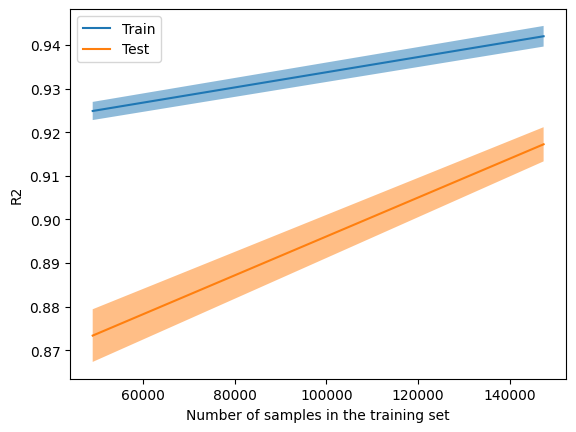

In [14]:
kneighbors = KNeighborsRegressor(n_neighbors = 5)
bagged_kn = BaggingRegressor(kneighbors, n_estimators = 3)

# cv_score = cross_val_score(bagged_kn, X_train_proc, y_train, scoring = "r2", cv=5, n_jobs = -1)
# cv_score

LearningCurveDisplay.from_estimator(bagged_kn, X_proc, y, train_sizes = [0.1, 0.3], scoring = "r2", cv=5, n_jobs = -1) 

### XGBoost

In [9]:
# xgb_cpu = XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.1)

In [9]:
xgb = XGBRegressor(max_depth=10, n_estimators=200, learning_rate=0.1, device = "cuda")

In [10]:
# cv_score = cross_val_score(bagged_kn, X_train_proc, y_train, scoring = "r2", cv=5, n_jobs = -1)
# cv_score

In [11]:
# xgb_cpu.fit(X_train, y_train,
#     # evaluate loss at each iteration
#     eval_set=[(X_train, y_train), (X_val, y_val)]#,  
#     # stop iterating when eval loss increases 5 times in a row
#     # early_stopping_rounds=5
# )

In [12]:
xgb.fit(X_train, y_train,
    # evaluate loss at each iteration
    eval_set=[(X_train, y_train), (X_val, y_val)]#,  
    # stop iterating when eval loss increases 5 times in a row
    # early_stopping_rounds=5
)

[0]	validation_0-rmse:4905.67634	validation_1-rmse:5022.51947
[1]	validation_0-rmse:4429.04706	validation_1-rmse:4542.44618
[2]	validation_0-rmse:3998.49912	validation_1-rmse:4108.94862
[3]	validation_0-rmse:3611.37586	validation_1-rmse:3719.03575
[4]	validation_0-rmse:3262.10997	validation_1-rmse:3368.20220
[5]	validation_0-rmse:2947.61851	validation_1-rmse:3052.43932
[6]	validation_0-rmse:2664.18915	validation_1-rmse:2768.36153
[7]	validation_0-rmse:2408.73412	validation_1-rmse:2512.18105
[8]	validation_0-rmse:2178.53833	validation_1-rmse:2281.09707
[9]	validation_0-rmse:1971.14969	validation_1-rmse:2073.96224
[10]	validation_0-rmse:1784.27358	validation_1-rmse:1887.41975
[11]	validation_0-rmse:1615.83893	validation_1-rmse:1721.24979
[12]	validation_0-rmse:1463.54879	validation_1-rmse:1576.00368
[13]	validation_0-rmse:1326.60466	validation_1-rmse:1441.69446
[14]	validation_0-rmse:1202.87522	validation_1-rmse:1322.33315
[15]	validation_0-rmse:1090.38603	validation_1-rmse:1215.94825
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

#### Scoring the XGBoost model

In [13]:
y_pred_val = xgb.predict(X_val)
y_pred_val

array([5932.9927 ,  716.10913,  544.55396, ..., 1054.9717 , 2301.71   ,
       2213.8052 ], dtype=float32)

In [14]:
y_pred_test = xgb.predict(X_test)
y_pred_test

array([ 3176.1284,  6101.3447,  5684.684 , ...,  4049.8054, 20323.334 ,
        1230.94  ], dtype=float32)

In [15]:
# xgb_cpu.predict(X_val)

In [16]:
xgb.score(X_val, y_val)

0.9951525185381551

In [17]:
xgb.score(X_test, y_test)

0.9973310511999025

In [18]:
mean_squared_error(y_val, y_pred_val)

149587.7272109732

In [19]:
np.sqrt(mean_squared_error(y_val, y_pred_val))

386.7657265205556

In [20]:
mean_absolute_error(y_val, y_pred_val)

22.68072459831771

In [45]:
y_test.head()

SalesKey
2384552     5880.0000
2384557    13278.6220
2384565      115.4615
2384572    10887.2000
2384585      359.8800
Name: SalesAmount, dtype: float64

#### Looks pretty good! The model's SalesAmount predictions are on average off by only 20-30 $ !

#### TO DO: Plot observed and predicted data

In [46]:
y_pred_test

array([ 5888.641  , 13447.425  ,   115.00366, ...,  3864.3281 ,
       20310.965  ,  1241.8059 ], dtype=float32)

In [47]:
y_test

SalesKey
2384552     5880.0000
2384557    13278.6220
2384565      115.4615
2384572    10887.2000
2384585      359.8800
              ...    
3406074     5235.5240
3406075      140.3000
3406083     3854.8715
3406088    20310.7500
3406089     1226.4000
Name: SalesAmount, Length: 184025, dtype: float64

In [35]:
def plot_prediction_with_val(y_pred_val, y_pred_test, y_train, y_val, y_test, upper=None, lower=None):
        is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
        # Prepare plot series
        y_pred_val_series = pd.Series(y_pred_val, index = y_val.index)
        y_pred_test_series = pd.Series(y_pred_test, index = y_test.index)
        lower_val_series = pd.Series(upper, index = y_val.index) if is_confidence_int else None
        upper_val_series = pd.Series(lower, index = y_val.index) if is_confidence_int else None
        lower_test_series = pd.Series(upper, index = y_test.index) if is_confidence_int else None
        upper_test_series = pd.Series(lower, index = y_test.index) if is_confidence_int else None

        # Plot
        plt.figure(figsize=(10,4), dpi=100)
        plt.plot(y_train[::5000], label='training', color='black')
        plt.plot(y_val[::5000], label='validation data', color='black', ls='--')
        plt.plot(y_test[::5000], label='test data', color='black', ls=':')
        if is_confidence_int:
            plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
        plt.title('Prediction vs Actual Validation and Test Values')
        plt.plot(y_pred_val_series[::5000], label='val prediction', color='blue')
        plt.plot(y_pred_test_series[::5000], label='test prediction', color='lightblue')
        plt.legend(loc='upper left', fontsize=8);

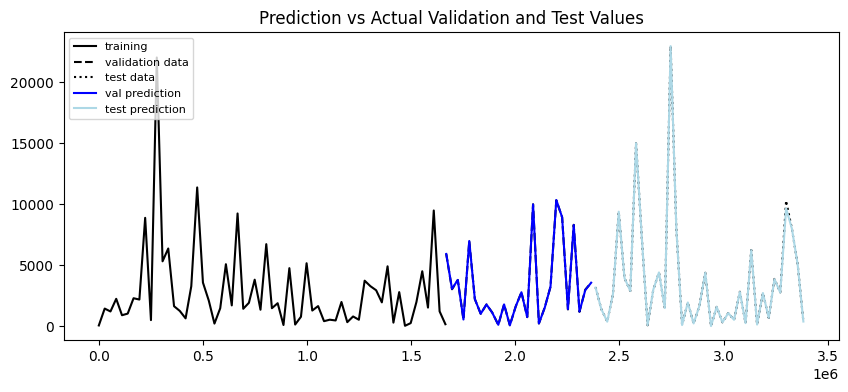

In [36]:
plot_prediction_with_val(y_pred_val, y_pred_test, y_train, y_val, y_test)

# Testing out predictions with knowable facts only

In [14]:
import salesninja.ml as ml

In [22]:
### For now, let's work with the dataset prepared by Nishi
data = pd.read_csv("../merged_data/data_ml_merged.csv", header = 0, skiprows = skipindices)

data.set_index(['SalesKey'], inplace=True)
data['DateKey'] = pd.to_datetime(data['DateKey'], infer_datetime_format=True)

print(data.shape)
data.head()

(681219, 40)


,DateKey,channelKey,StoreKey,ProductKey,PromotionKey,UnitCost,UnitPrice,SalesQuantity,ReturnQuantity,ReturnAmount,...,ProductCategoryKey,GeographyKey,StoreType,EmployeeCount,SellingAreaSize,GeographyType,ContinentName,CityName,StateProvinceName,RegionCountryName
SalesKey,,,,,,,,,,,,,,,,,,,,,
8,2008-04-10,2,307,138,15,229.93,499.99,9,0,0.0,...,2.0,710,Online,8,93800,City,Asia,Beijing,Beijing,China
13,2007-07-25,1,171,739,3,78.19,236.00,12,0,0.0,...,3.0,932,Store,25,700,City,North America,South Portland,Maine,United States
14,2008-12-16,1,16,1269,13,25.47,49.96,13,0,0.0,...,4.0,627,Store,17,462,City,North America,Everett,Washington,United States
22,2008-02-29,1,155,189,11,58.36,126.90,9,0,0.0,...,2.0,832,Store,25,700,City,North America,Framingham,Massachusetts,United States
33,2009-01-25,1,178,824,20,6.07,11.90,18,0,0.0,...,3.0,864,Store,25,700,City,North America,Litchfield County,Connecticut,United States


In [45]:
X = data.drop(columns = ["SalesAmount"])
y = data["SalesAmount"]

In [58]:
X_facts = ml.preprocessor.extract_prediction_facts(X)
X_facts.head()

,DateKey,PromotionKey,DiscountPercent,CalendarYear,CalendarQuarterLabel,CalendarWeekLabel,IsWorkDay,MonthNumber,CalendarDayOfWeekNumber
SalesKey,,,,,,,,,
8,2008-04-10,15,0.20,2008,Q2,Week 15,WorkDay,4,4
13,2007-07-25,3,0.10,2007,Q3,Week 30,WorkDay,7,3
14,2008-12-16,13,0.20,2008,Q4,Week 51,WorkDay,12,2
22,2008-02-29,11,0.05,2008,Q1,Week 9,WorkDay,2,5
33,2009-01-25,20,0.05,2009,Q1,Week 5,WeekEnd,1,7


In [59]:
from sklearn.preprocessing import OneHotEncoder

In [60]:
X_facts.reset_index(inplace = True)
X_facts.drop(columns = ["DateKey"], inplace = True)

cat_trans = make_column_transformer([OneHotEncoder(handle_unknown='ignore', drop = "if_binary"), ["CalendarQuarterLabel", "CalendarWeekLabel", "IsWorkDay"]], remainder='passthrough')
X_facts = cat_trans.fit_transform(X_facts)

X_facts

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5702844 stored elements and shape (681219, 64)>

In [62]:
X_facts_train, X_facts_test, y_facts_train, y_facts_test = train_test_split(X_facts, y, test_size = 0.3, shuffle = False)

In [63]:
xgb_facts = XGBRegressor(max_depth=10, n_estimators=100, learning_rate=0.1, enable_categorical=True, device = "cuda")

xgb_facts.fit(X_facts_train, y_facts_train,
    # evaluate loss at each iteration
    eval_set=[(X_facts_train, y_facts_train), (X_facts_test, y_facts_test)]#,  
    # stop iterating when eval loss increases 5 times in a row
    # early_stopping_rounds=5
)

[0]	validation_0-rmse:5307.68592	validation_1-rmse:5289.26506
[1]	validation_0-rmse:5295.73454	validation_1-rmse:5287.87634
[2]	validation_0-rmse:5284.96722	validation_1-rmse:5290.35974
[3]	validation_0-rmse:5275.80883	validation_1-rmse:5296.27530
[4]	validation_0-rmse:5268.09758	validation_1-rmse:5300.94888
[5]	validation_0-rmse:5261.38227	validation_1-rmse:5306.58456
[6]	validation_0-rmse:5255.55036	validation_1-rmse:5310.40007
[7]	validation_0-rmse:5250.40820	validation_1-rmse:5319.19320
[8]	validation_0-rmse:5244.58357	validation_1-rmse:5327.82698
[9]	validation_0-rmse:5239.89437	validation_1-rmse:5335.63115
[10]	validation_0-rmse:5235.59194	validation_1-rmse:5339.14818
[11]	validation_0-rmse:5231.58578	validation_1-rmse:5356.57809
[12]	validation_0-rmse:5227.62465	validation_1-rmse:5360.38700
[13]	validation_0-rmse:5223.78939	validation_1-rmse:5372.03144
[14]	validation_0-rmse:5220.52176	validation_1-rmse:5382.89135
[15]	validation_0-rmse:5217.29303	validation_1-rmse:5390.01059
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [64]:
xgb_facts.score(X_facts_train, y_facts_train)

/home/kai/.pyenv/versions/3.10.6/envs/sales-ninja/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [21:51:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


0.09948797455040159

In [66]:
xgb_facts.score(X_facts_test, y_facts_test)

-0.15197639888148107

In [78]:
from sklearn.metrics import r2_score

In [67]:
y_pred = xgb_facts.predict(X_facts_test)

In [81]:
y_baseline = y_facts_test.mean()
y_baseline

3634.5616818878875

In [70]:
mean_squared_error(y_facts_test, y_pred)

32312344.20834096

In [71]:
mean_absolute_error(y_facts_test, y_pred)

3337.004295194923

In [82]:
r2_score(y_facts_test, y_pred)

-0.15197639888148107

In [76]:
def plot_prediction(y_pred, y_train, y_test, upper=None, lower=None):
        is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
        # Prepare plot series
        y_pred_series = pd.Series(y_pred, index = y_test.index)
        lower_series = pd.Series(upper, index = y_test.index) if is_confidence_int else None
        upper_series = pd.Series(lower, index = y_test.index) if is_confidence_int else None

        # Plot
        plt.figure(figsize=(10,4), dpi=100)
        plt.plot(y_train[::5000], label='training', color='black')
        plt.plot(y_test[::5000], label='test data', color='black', ls=':')
        if is_confidence_int:
            plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
        plt.title('Prediction vs Actual Validation and Test Values')
        plt.plot(y_pred_series[::5000], label='test prediction', color='lightblue')
        plt.legend(loc='upper left', fontsize=8);

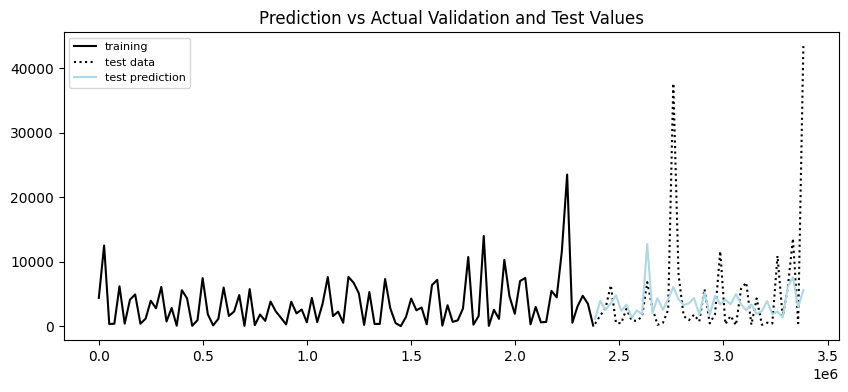

In [77]:
plot_prediction(y_pred, y_facts_train, y_facts_test)